# Pressure

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_surface import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/P_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
surface_mask = train_dataset.surface_mask

linear_ae_input_size = torch.flatten(train_dataset[0].x).shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

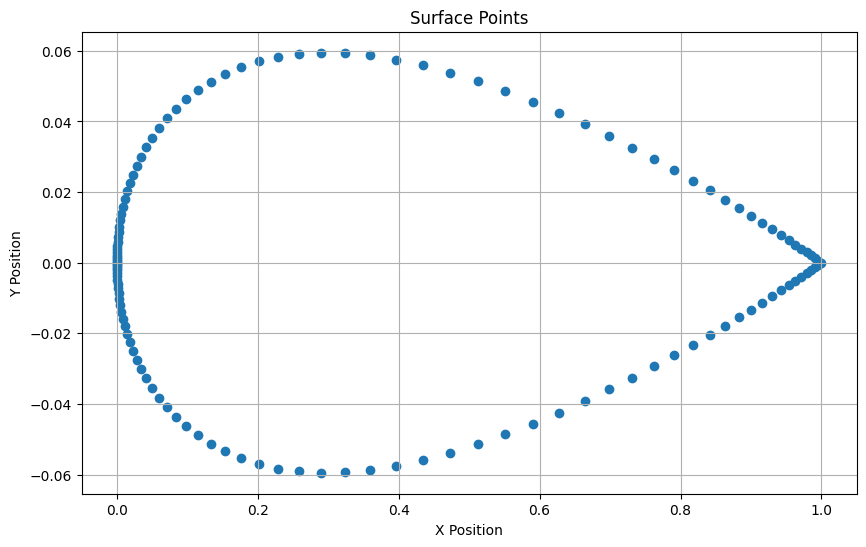

In [2]:
import matplotlib.pyplot as plt
surface_point = train_dataset[0].pos[surface_mask, :]
plt.figure(figsize=(10, 6))
plt.scatter(surface_point[:, 0].cpu().numpy(), surface_point[:, 1].cpu().numpy())
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Surface Points')
plt.grid(True)
plt.show()

## Training

In [3]:
print(f"Training model {config['training']['model_name']} with {len(train_dataset)} training samples and {len(val_dataset)} validation samples.")

Training model NACA0012_SAGEConv_P with 35 training samples and 323 validation samples.


Check if model parameters are loaded correctly and training starts as expected.

In [4]:
print("============================MODEL SPEC===========================")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
total = sum(p.numel() for p in optimizer.param_groups[0]['params'])
print(f"Number of trainable parameters: {total}")
print(model)

print("\n\n============================REQUIRES GRAD===========================")

for name, param in model.named_parameters():
    print(f"{name:50} requires_grad = {param.requires_grad}")

print("\n\n============================GRAD NORM===========================")

for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name:50} grad norm = {param.grad.norm():.4e}")
    else:
        print(f"{name:50} has no gradient")

============================MODEL SPEC===========================
Number of trainable parameters: 30340106
GAE(
  (graph_encoder): GraphEncoder(
    (convolution_layers): ConvolutionLayers(
      (dropout): Dropout(p=0, inplace=False)
      (convs): ModuleList(
        (0): SAGEConv(1, 32, aggr=mean)
        (1-2): 2 x SAGEConv(32, 32, aggr=mean)
        (3): SAGEConv(32, 1, aggr=mean)
      )
      (batch_norms): ModuleList(
        (0-2): 3 x LayerNorm(32, affine=True, mode=graph)
        (3): LayerNorm(1, affine=True, mode=graph)
      )
    )
  )
  (graph_decoder): GraphDecoder(
    (convolution_layers): ConvolutionLayers(
      (dropout): Dropout(p=0, inplace=False)
      (convs): ModuleList(
        (0): SAGEConv(1, 32, aggr=mean)
        (1-2): 2 x SAGEConv(32, 32, aggr=mean)
        (3): SAGEConv(32, 1, aggr=mean)
      )
      (batch_norms): ModuleList(
        (0-2): 3 x LayerNorm(32, affine=True, mode=graph)
        (3): LayerNorm(1, affine=True, mode=graph)
      )
    )
  

Training

In [5]:
history = train(model = model, 
                device = device, 
                surface_mask = surface_mask,
                lambda_surface=1,
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=20,
                save_best_model=True,
                save_history=True,
                config = config['training'])

train_history, val_history = history


100%|██████████| 5000/5000 [2:38:18<00:00,  1.90s/it, train_loss=0.265375, map_loss=0.002292, reconstruction_loss=0.263082, val_loss=0.309230, val_reconstruction_loss=0.306573, val_map_loss=0.002657]  


In [6]:
from src.utils.commons import save_config
save_config(config, task='surface')

### Plot train total loss and val total loss

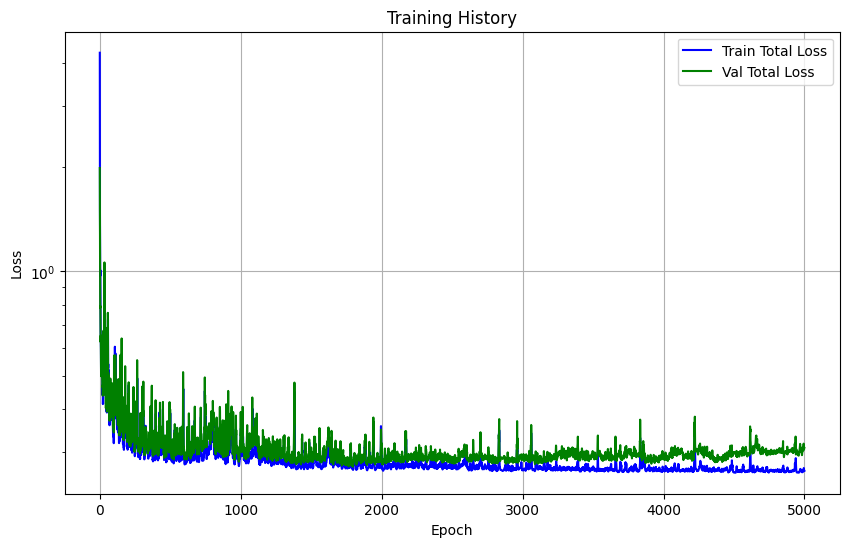

In [7]:
import pickle
import matplotlib.pyplot as plt
from src.utils.commons import get_config

config = get_config('configs/P_NACA0012.yaml')
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

# check if train_history and val_history exist
with open(f"artifacts/surface/{model_name}/{model_name}_history_{num_epochs}.pkl", 'rb') as f:
    # Load the history dictionary
    train_history = pickle.load(f)
    val_history = pickle.load(f)
    
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']    

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot train loss history

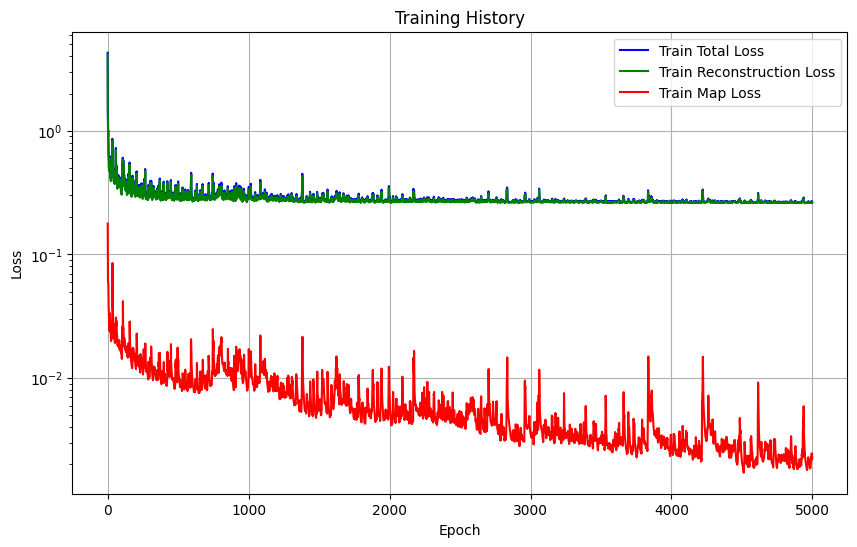

In [8]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot validation loss history

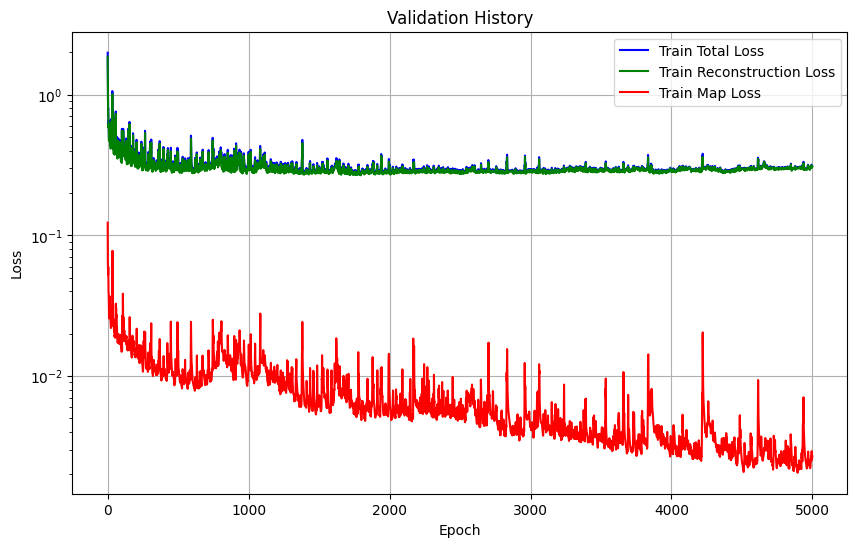

In [9]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot results

### Matplotlib Plotting

In [10]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/P_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']
model_name = config['training']['model_name']

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

Original

In [11]:
import pickle

with open(r"dataset/h5_files/scaler.pkl", 'rb') as f:
    scaler = f.read()

Using v_range: 2.0295398235321045


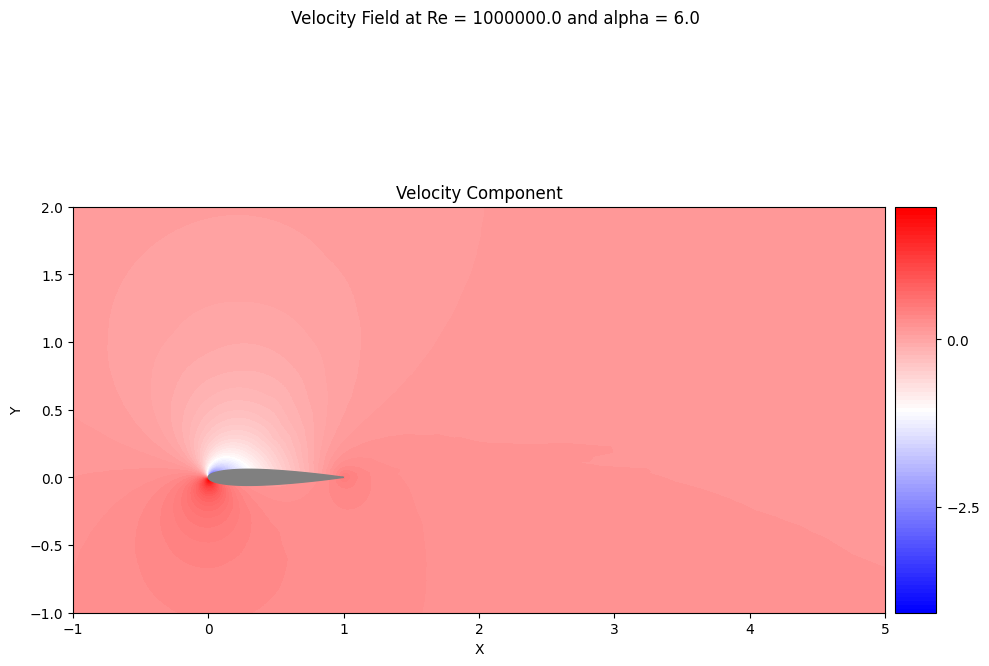

In [12]:
index = 10

test_plot_data = val_dataset[index].to(device)
test_param = test_plot_data.params

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()

plot.plot_velocity_field(data=test_plot_data, title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')

In [13]:
# # def plot_velocity_field(self, data: Data, title: str = "Velocity Field", save = False, xlim=None, ylim=None, v_range=None, colormap='bwr'):
# #     if data.pos is None or data.x is None:
# #         print("Error: `data.pos` or `data.x` is None. Cannot plot velocity field.")
# #         return

# import matplotlib
# import matplotlib.tri
# import matplotlib.ticker as ticker
# import matplotlib.colors as mcolors
# import numpy as np
# colormap = "bwr"
# v_range = None  # Set to None to use the maximum absolute value for normalization
# data = test_plot_data
# x_coord = data.pos[:,0].detach().cpu().numpy()
# y_coord = data.pos[:,1].detach().cpu().numpy()
# vel = data.x.detach().cpu().numpy()

# num_components = 1 if vel.ndim == 1 else vel.shape[1]

# if num_components == 2:
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
#     axes = [ax1, ax2]
#     comp_titles = ['Ux Component', 'Uy Component']
# else:
#     fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
#     axes = [ax1]
#     comp_titles = ['Velocity Component']

# triang = matplotlib.tri.Triangulation(x_coord, y_coord)
# fmt = ticker.ScalarFormatter(useMathText=True)
# fmt.set_powerlimits((0, 0))

# for i, ax in enumerate(axes):
#     vel_comp = vel.squeeze() if num_components == 1 else vel[:, i]

#     if v_range is not None:
#         norm = mcolors.Normalize(vmin=v_range[0], vmax=v_range[1])
#     else:
#         # Use the maximum absolute value for normalization if v_range is not provided
#         v_range = np.max([vel_comp.max(), np.abs(vel_comp.min())])
#         print(f"Using v_range: {v_range}")
#         norm = mcolors.Normalize(vmin=-v_range, vmax=v_range)
    
#     cs = ax.tricontourf(triang, vel_comp, 100, cmap=colormap, norm=norm)

In [14]:
model.graph_decoder

GraphDecoder(
  (convolution_layers): ConvolutionLayers(
    (dropout): Dropout(p=0, inplace=False)
    (convs): ModuleList(
      (0): SAGEConv(1, 32, aggr=mean)
      (1-2): 2 x SAGEConv(32, 32, aggr=mean)
      (3): SAGEConv(32, 1, aggr=mean)
    )
    (batch_norms): ModuleList(
      (0-2): 3 x LayerNorm(32, affine=True, mode=graph)
      (3): LayerNorm(1, affine=True, mode=graph)
    )
  )
)

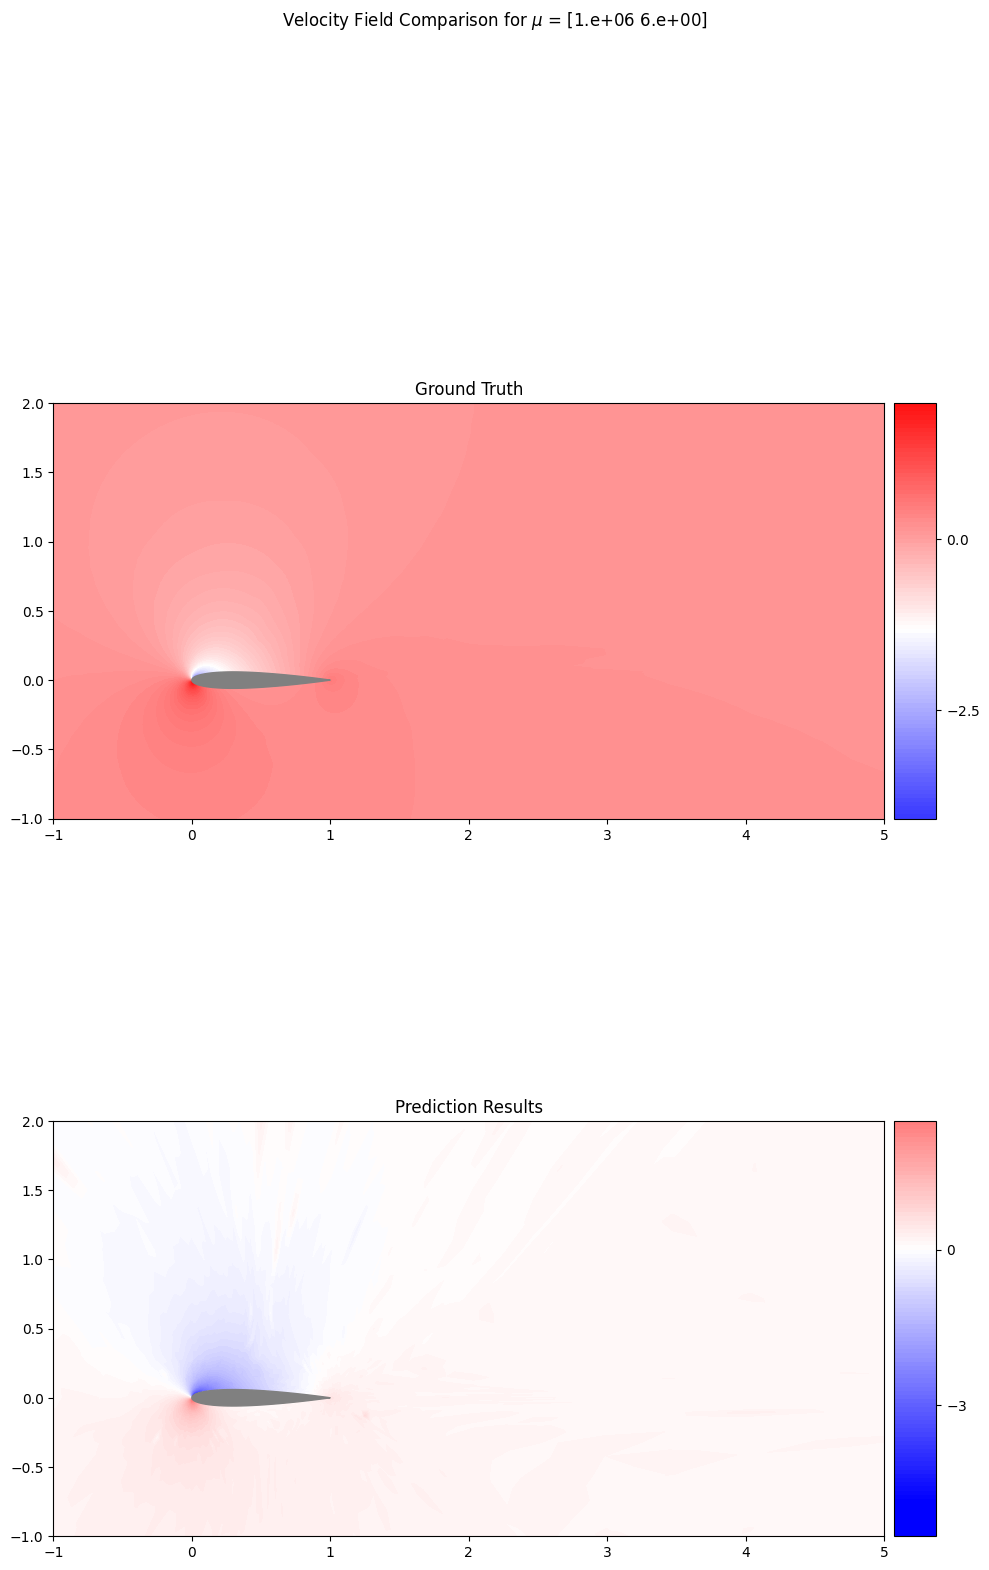

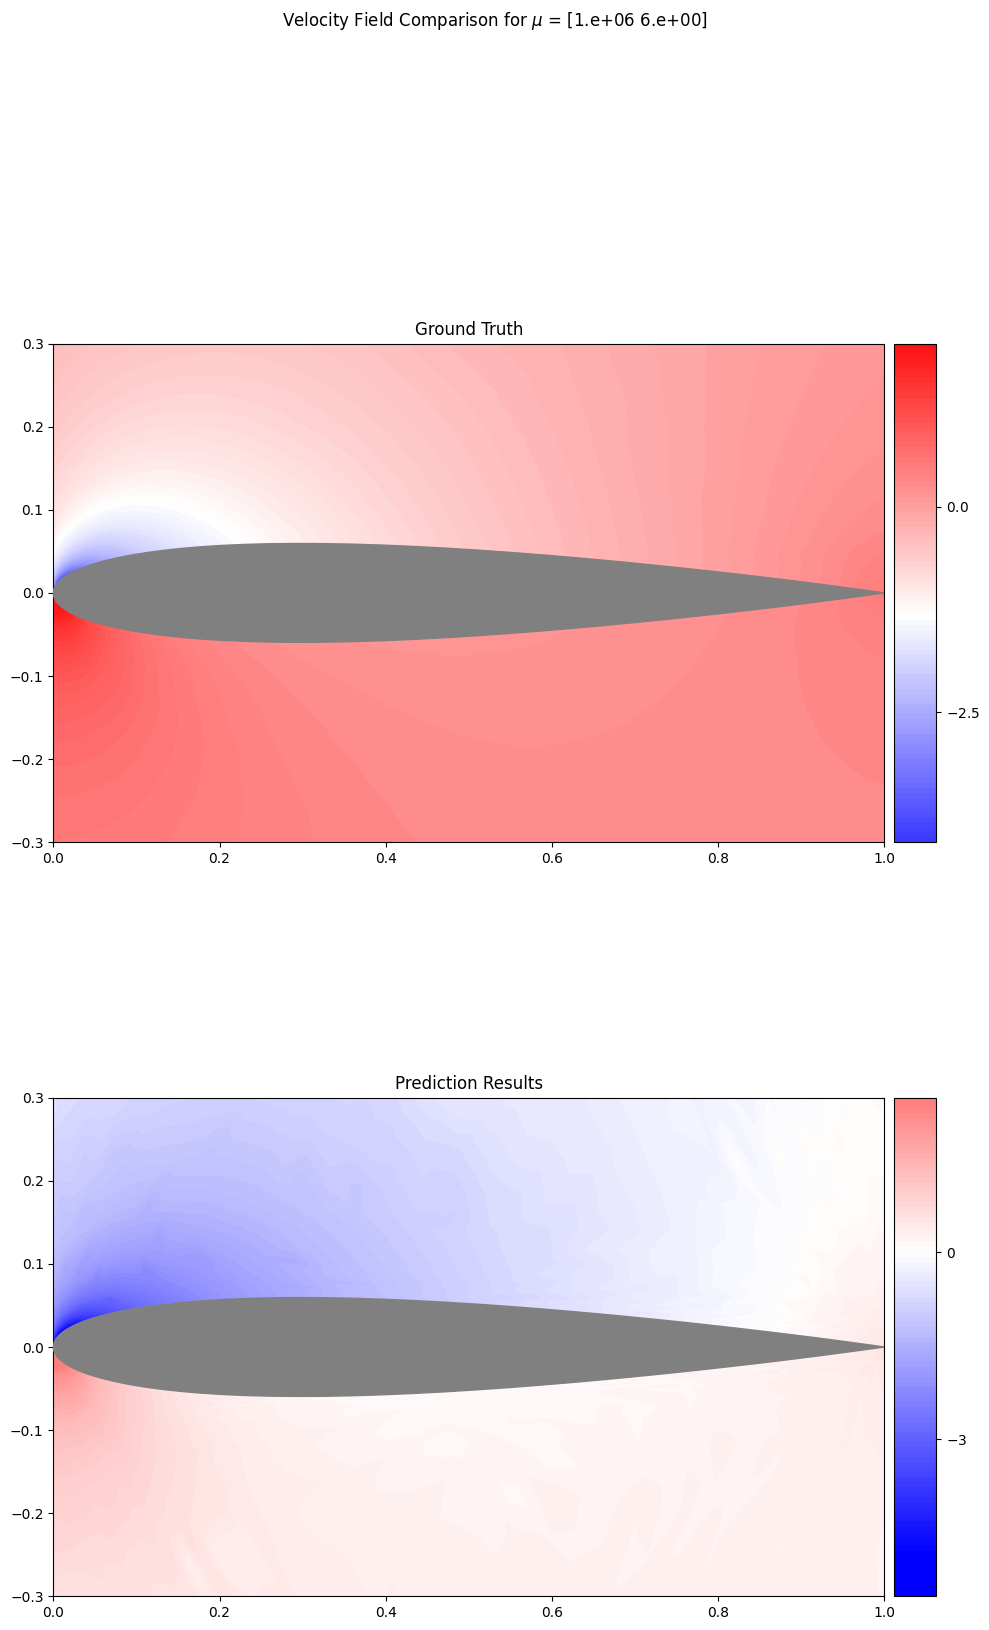

In [15]:
plot.plot_comparison_fields(SNAP = index, device = device, dataset = val_dataset, params = test_param, grid="vertical", colormap='bwr', xlim=[-1, 5], ylim=[-1, 2])

plot.plot_comparison_fields(SNAP = index, 
                            device = device,
                            dataset = val_dataset, 
                            params = test_param, grid="vertical", 
                            colormap='bwr', 
                            # xlim=[-1, 5], ylim=[-1, 2]
                            xlim=[0, 1], ylim=[-0.3, 0.3]
                            )

MSE Error

In [16]:
def relative_error(pred, target, eps=1e-8):
    return torch.abs(pred - target) / (torch.abs(target) + eps)

In [17]:
from torch.nn.functional import mse_loss
# error = relative_error(pred=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x)
error= mse_loss(input=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x, reduction='mean')
print(f"Mean Squared Error: {error.item()}")

Mean Squared Error: 0.058010995388031006


Using v_range: 1.3033952713012695


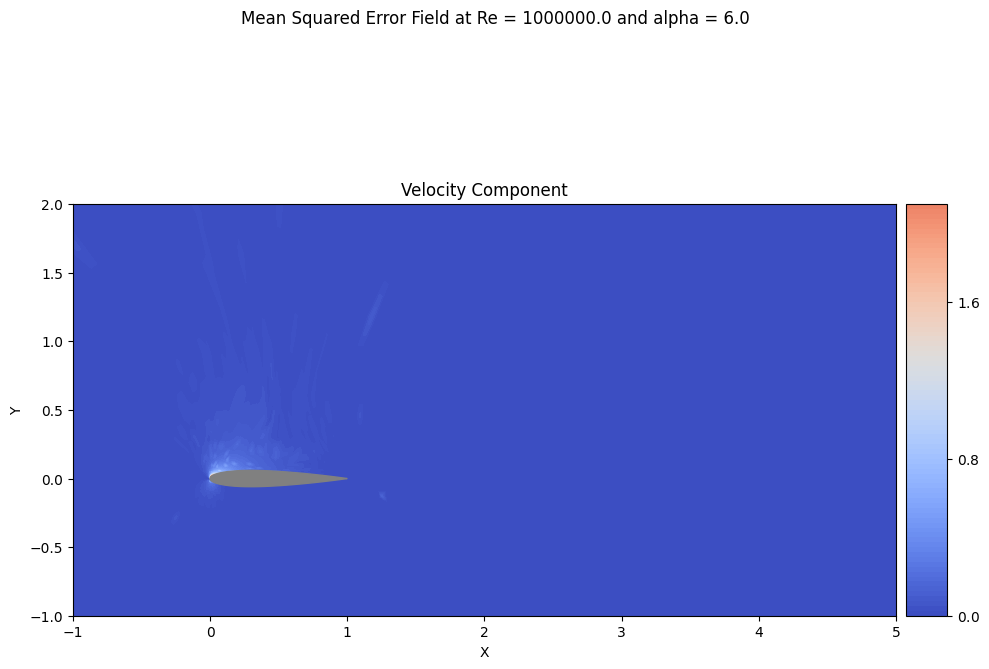

Using v_range: 1.3033959865570068


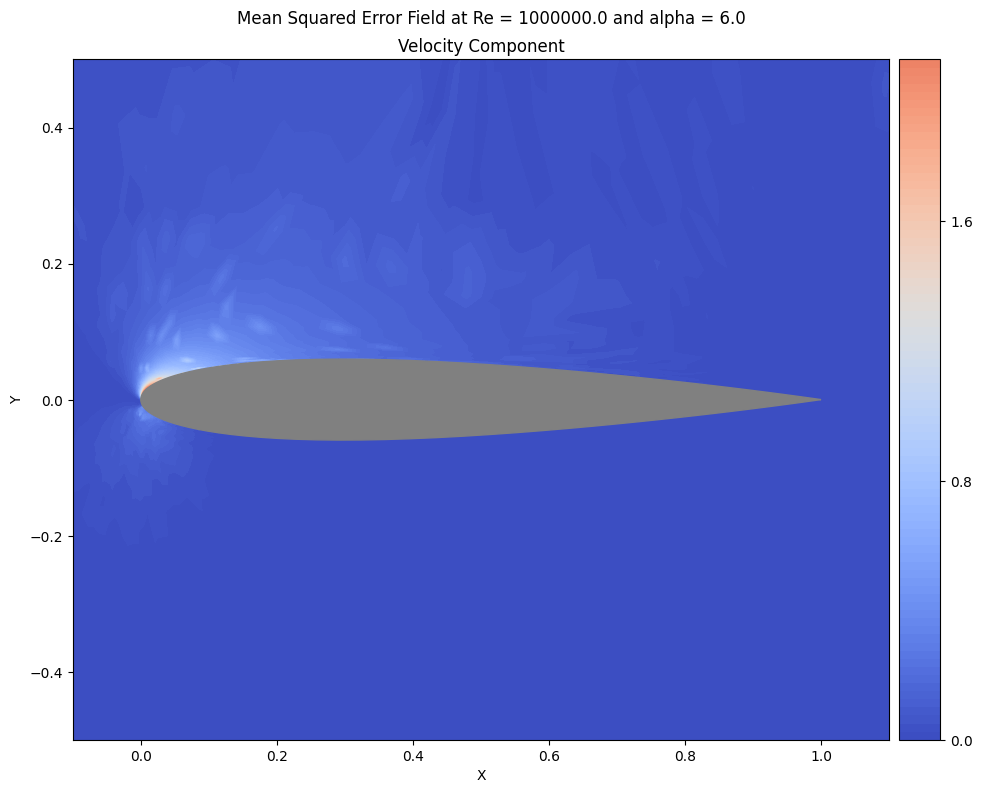

Using v_range: 1.3033945560455322


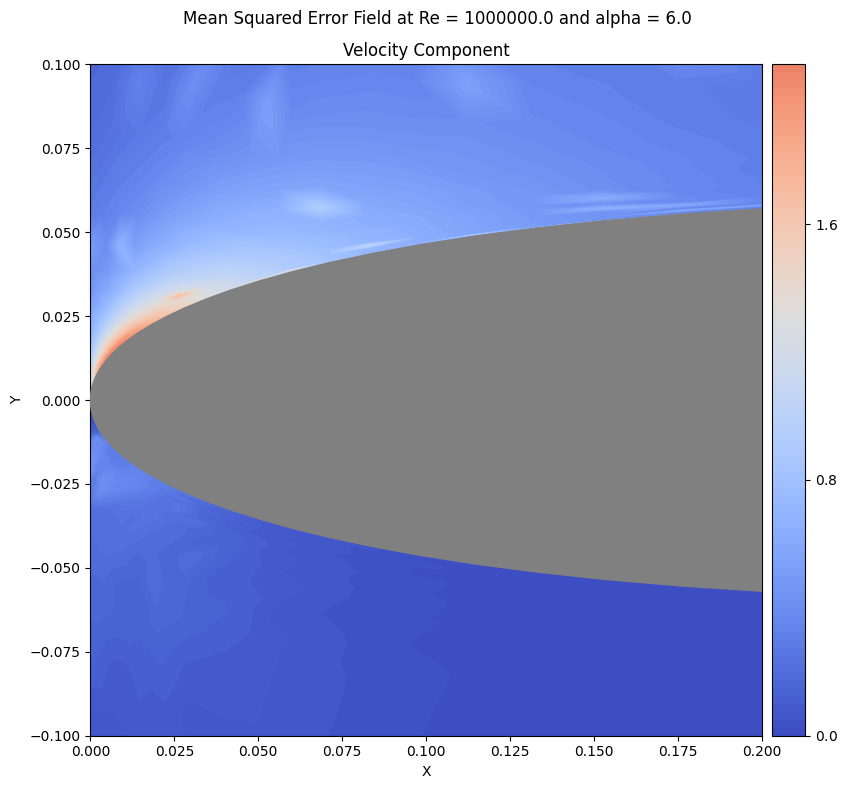

In [ ]:
# v_range=[-0.17144335806369781, 0.17144335806369781]
v_range = None
colormap='coolwarm'

plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[-1, 5], ylim=[-1, 2], 
                               colormap=colormap)

plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[-0.1, 1.1], ylim=[-0.5, 0.5], 
                               colormap=colormap)

plot.plot_velocity_field_error(data=test_plot_data, 
                               params=test_param, device = device, 
                               title=f"Mean Squared Error Field at Re = {test_param[0]} and alpha = {test_param[1]}", 
                               save=False, 
                               v_range=v_range,
                               xlim=[0, 0.2], ylim=[-0.1, 0.1], 
                               colormap=colormap)

### Pyvista Plotting

In [19]:
from src.utils.plot import PyvistaPlot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/P_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']

test_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)
plot = PyvistaPlot(vtu_dir = "dataset/flows", model=model, dataset=test_dataset)

In [20]:
import pyvista as pv
index = 1
mesh = pv.read(f"dataset/full/flow_{test_dataset.file_keys[index]}.vtu")
mesh.clear_data()
mesh.point_data["Pressure"] = test_dataset[index].x.detach().cpu().numpy()
mesh
# mesh.write_vtu("dataset/flows/configuration_0.vtu")

UnstructuredGrid (0x152891b4b80)
  N Cells:    14336
  N Points:   14576
  X Bounds:   -4.845e+02, 5.010e+02
  Y Bounds:   -5.078e+02, 5.078e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

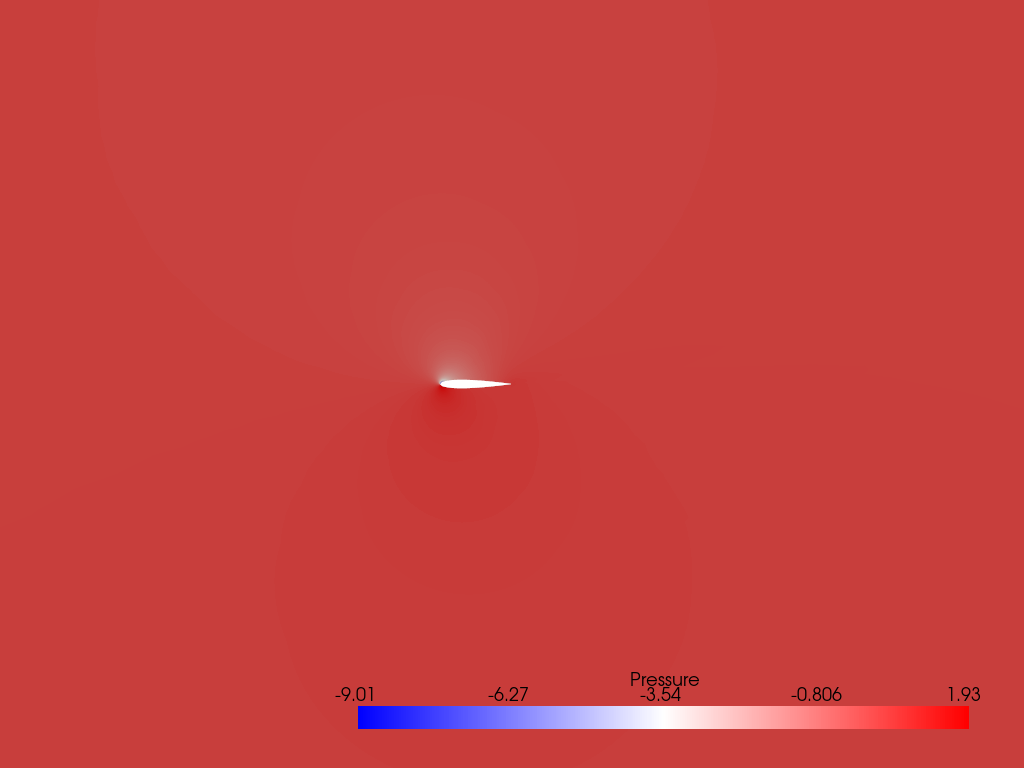

In [21]:
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars='Pressure', cmap='bwr')
plotter.view_xy()
# plotter.zoom_camera(1)
plotter.camera_position = [
    (0, 0, 20),   # camera location
    (1, 0, 0),      # focal point (center of the mesh)
    (0, 0, 0)       # view up vector (Z axis is "up")
]
# plotter.legend()
# plotter.
# plotter.set_focal_point([0, 0, 0])
plotter.show()

# Post processing

In [22]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
# from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from torch_geometric.loader import DataLoader
from src.data.loader import GraphDataset
from src.utils.commons import get_config, load_model

# filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/P_NACA0012.yaml')
set_seed(config['config']['seed'])
device = get_device()
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

test_dataset = GraphDataset(config = config['config'], split = 'val')
test_loader = DataLoader(dataset=test_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

surface_mask = test_dataset.surface_mask
num_graphs = test_dataset.num_graphs

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, ae_input_ize=test_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])
model = model.to(device)

In [23]:
model.graph_encoder(test_dataset[0].x.to(device))

AttributeError: 'Tensor' object has no attribute 'x'

In [ ]:
""" BECAREFUL FOR SOME REASON THIS ALWAYS CRASHES THE NOTEBOOK """

# from src.utils.metrics import mse_error, mae_error, rmse_error, relative_error
# from src.training.test import test

# error_func = [mse_error, mae_error, rmse_error, relative_error]
# test_results, total_error = test(model = model, test_loader=test_loader, device=device, error_func=error_func)

# Cp

Good: 5, 6
Hmm: 3, 4, 8
Bad: 1, 2, 9, 10, 11

In [ ]:
index = 5

In [ ]:
from src.training.test import single_test

rho_inf = 2.13163
R = 287.058
T_inf = 300
viscosity_inf = 1.853e-05
v_inf = 52.1572 # THIS HAS TO BE CHANGED FOR EACH RE

p_inf = rho_inf * R * T_inf
q_inf = 0.5 * rho_inf * v_inf**2

model = model.to(device)
test_data = test_dataset[index]
test_data = test_data.to(device)
test_param = test_data.params.to(device)
file_key = test_dataset.file_keys[index]
surface_mask = test_dataset.surface_mask
surface_point = test_data.pos[surface_mask].detach().cpu().numpy()
upper_surface_point = surface_point[surface_point[:, 1] >= 0]
lower_surface_point = surface_point[surface_point[:, 1] < 0]

# VTU FILE
# import pyvista as pv
# import meshio
# vtu_path = f"dataset/full/flow_Re_{int(test_param[0])}_alpha_{int(test_param[1])}.vtu"
# mesh_path = r"dataset/unsteady_naca0012.su2"
# grid = pv.read(vtu_path)
# surface_p = grid["Pressure"][surface_mask,]
# surface_cp = grid["Pressure_Coefficient"][surface_mask,]
# surface_p.shape

# truth
surface_p_graph = test_data.x[surface_mask].detach().cpu().numpy()
surface_cp_graph = test_dataset.h5_file[file_key]['Cp'][:][surface_mask]
surface_cp_graph = (surface_p_graph - p_inf) / q_inf
surface_p_graph.shape

#predicted
pred_p = single_test(model, test_param, test_data, device).detach().cpu().numpy()
surface_pred_p = pred_p[surface_mask,]
surface_pred_cp = (surface_pred_p - p_inf) / q_inf
surface_pred_p.shape

cp_mse = np.mean((surface_cp_graph - surface_pred_cp) ** 2)
print(f"MSE: {cp_mse}")
cp_relative = np.mean(np.abs(surface_pred_cp - surface_cp_graph) / np.abs(surface_cp_graph))
print(f"Relative Error: {cp_relative}")

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], surface_cp_graph, label="True Pressure Coefficient", color="blue")
plt.scatter(surface_point[:, 0], surface_pred_cp, label="Predicted Pressure Coefficient", color="red", marker="*")
plt.ylim(max([max(surface_cp_graph), max(surface_pred_cp)]), min([min(surface_cp_graph), min(surface_pred_cp)]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], np.abs(surface_cp_graph - surface_pred_cp), label="Absolute Error", color="blue")
plt.ylim(0, max([max(np.abs(surface_cp_graph - surface_pred_cp))]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

In [ ]:
# lambda_surface = min_lambda + (max_lambda - min_lambda) * (epoch / total_epochs)

In [ ]:
model = model.to(device)
test_params = test_dataset[0].to(device).params
model.eval()


In [ ]:
test_params

In [ ]:
with torch.no_grad():
    latent_var = model.mapping(test_params)
    decoded_x = model.linear_autoencoder.decoder(latent_var)
    # pred_x = model.graph_decoder(test_dataset[0], decoded_x) ### thisss

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_p_graph, cmap="coolwarm", s=10)
plt.colorbar()
plt.title("True Pressure in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_p, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure in Graph")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_cp_graph, cmap="coolwarm")
plt.colorbar()
plt.title("True Pressure Coefficient (Cp) in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_cp, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure Coefficient (Cp) in Graph")
plt.show()